In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt
import theano
floatX = 'float32'
theano.config.floatX = floatX
theano.config.profile = True
theano.config.profile_memory = True
import pymc3 as pm

from astropy.io import fits

In [2]:
boss_dupl = fits.open('cov/boss_duplicate_spectra.fit')
manga_dupl = fits.open('cov/manga_duplicate_spectra.fit')

In [3]:
import pandas as pd
from astropy import table as t

In [4]:
manga_dupl_tab = t.Table.read(manga_dupl)

spec1, spec2 = np.array(manga_dupl_tab['SPEC1']), np.array(manga_dupl_tab['SPEC2'])
err1, err2 = np.array(manga_dupl_tab['ERR1']), np.array(manga_dupl_tab['ERR2'])
wave = np.array(manga_dupl_tab['WAVE'][0])
wave_log = np.log10(wave)

Text(0.5, 1.0, 'Uncertainty range')

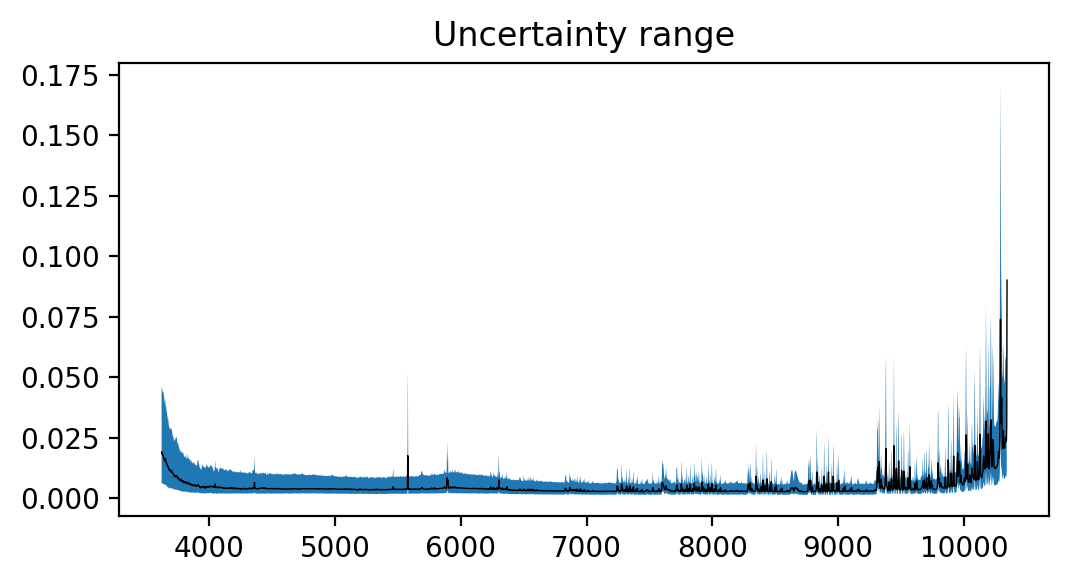

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=200)
err_pctl = np.percentile(np.row_stack([err1, err2]), [16., 50., 84.], axis=0)
ax.fill_between(wave, err_pctl[0], err_pctl[2])
ax.plot(wave, err_pctl[1], c='k', linewidth=0.5)
ax.set_title('Uncertainty range')

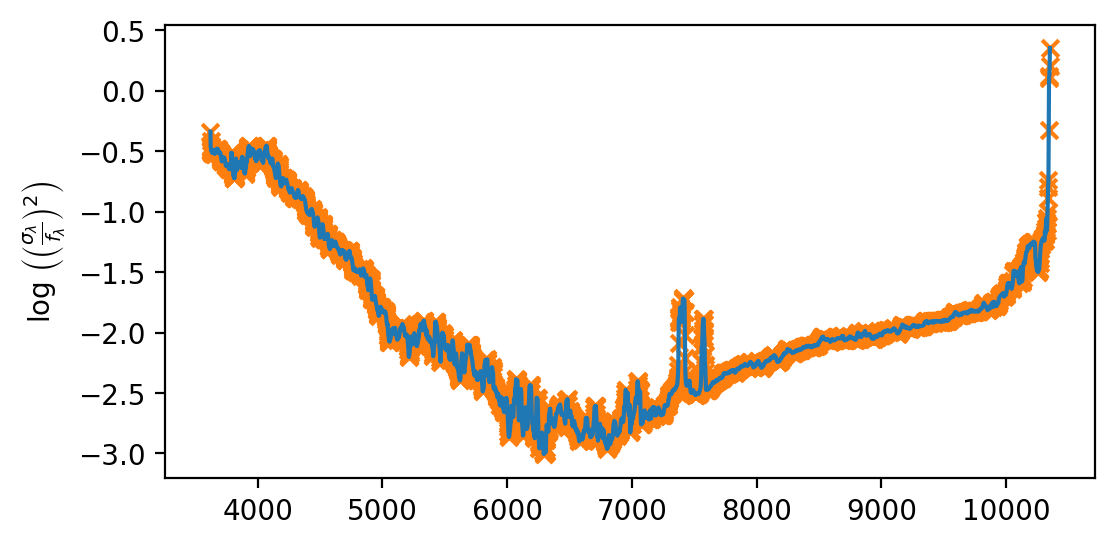

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=200)

spec_pctl = np.percentile(np.row_stack([spec1, spec2]), [5., 95.], axis=0)
spec_sd = np.row_stack([spec1, spec2]).std(axis=0)
spec_mean = np.row_stack([spec1, spec2]).mean(axis=0)
spec_normvar = (spec_sd / spec_mean)**2

good_var = np.isfinite(spec_normvar)
spec1, spec2 = spec1[:, good_var], spec2[:, good_var]
wave = wave[good_var]
spec_normvar = spec_normvar[good_var]

log_spec_normvar = np.log10(spec_normvar)

ax.plot(wave, log_spec_normvar)

dspec = (np.array(spec1) - np.array(spec2)).astype(floatX)
#dspec, wave = dspec[:, :100], wave[:100]
#spec_normvar, log_spec_normvar = spec_normvar[:100], log_spec_normvar[:100]
#dspec, wave = dspec[:, ::100], wave[::100]
#spec_normvar, log_spec_normvar = spec_normvar[::100], log_spec_normvar[::100]

ax.scatter(wave, log_spec_normvar, c='C1', marker='x')

ax.set_ylabel(r'$\log ~ \left( \left( \frac{\sigma_{\lambda}}{f_{\lambda}} \right)^2 \right)$')

n_obj, nl = dspec.shape

In [7]:
print(n_obj, nl)

85 4562


# Explicit smoothing

Consider a GP that we see multiple realizations of: that is, we measure two sets of data that are related, and we want to see **how** they are related. We use a multi-output GP, implemented with a coregionalization model.

/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')


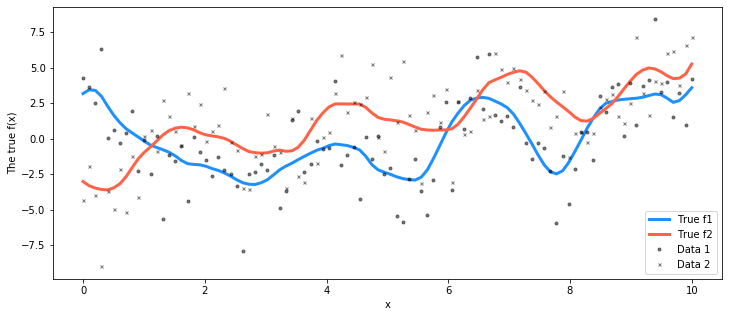

In [8]:
n = 100 
x = np.linspace(0, 10, n)[:, None] 

# true covariance function and its true parameters
ℓ_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, ℓ_true)
mean_func = pm.gp.mean.Zero()

# two samples from the same gaussian process
f_true1 = np.random.multivariate_normal(mean_func(x).eval(),
                                        cov_func(x).eval() + 1e-8*np.eye(n), 1).flatten()
f_true2 = np.random.multivariate_normal(mean_func(x).eval(),
                                        cov_func(x).eval() + 1e-8*np.eye(n), 1).flatten()


sigma_true = 2.0
f1 = 0.5*f_true1 - 1.0*f_true2
f2 = 1.0*f_true1 + 0.2*f_true2
y1 = f1 + sigma_true * np.random.randn(n)
y2 = f2 + sigma_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(x, f1, "dodgerblue", lw=3, label="True f1");
ax.plot(x, f2, "tomato", lw=3, label="True f2");
ax.plot(x, y1, 'ok', ms=3, alpha=0.5, label="Data 1");
ax.plot(x, y2, 'xk', ms=3, alpha=0.5, label="Data 2");
ax.set_xlabel("x"); ax.set_ylabel("The true f(x)"); plt.legend();

Now let's use a model nearer to the case of multiply-observed spectral differences.

In [9]:
xx = np.concatenate((x, x), axis=0)
idx = np.concatenate((np.zeros(n), np.ones(n)))[:,None]
X = np.concatenate((xx, idx), axis=1)

y = np.concatenate((y1, y2))
X.shape, y.shape

((200, 2), (200,))

In [10]:
with pm.Model() as model:
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sd=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = coreg * cov

    sigma = pm.HalfNormal("sigma", sd=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma) 

/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr

In [11]:
with model:
    mp = pm.find_MAP()

x_new = np.linspace(0, 20, 200)[:,None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(200), np.ones(200)))[:,None]
X_new = np.concatenate((xx_new, idx2), axis=1)

with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_ppc([mp], vars=[f_pred], samples=300)

/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] 

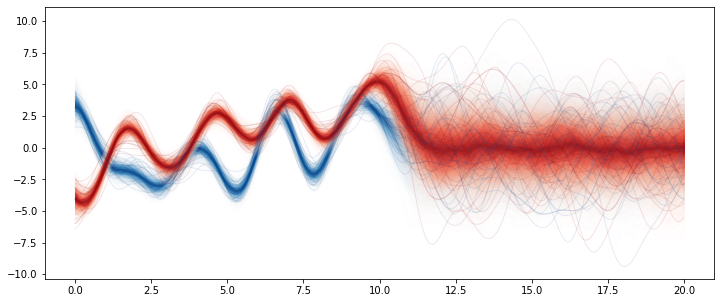

In [12]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

f_pred = pred_samples["f_pred"]
plot_gp_dist(ax, f_pred[:, :200], X_new[:200,0], palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plot_gp_dist(ax, f_pred[:, 200:], X_new[200:,0], palette="Reds", fill_alpha=0.1, samples_alpha=0.1);

In [13]:
var_dist = pm.InverseGamma.dist(alpha=2., beta=0.1)
noise_dist = pm.Normal.dist(mu=0., sd=1.)

X0 = np.linspace(0., 2. * np.pi, 100)
data0 = [np.sin(X0), np.sin(X0)]
data_obs = [d + noise_dist.random(size=X0.size) * np.sqrt(var_dist.random(size=X0.size)) for d in data0]
n_output = len(data_obs)
nsamples_per_output = X0.size

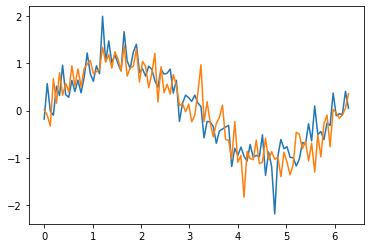

In [14]:
plt.plot(X0.flatten(), np.array(data_obs).T)

Some functions to help us build the input arrays and mock up outputs

In [9]:
def coregion_coords(Xs, n_output=None):
    """generate coordinate matrix for coregion GP
    """
    # start out evaluating dimensionality
    
    if n_output is not None:
        if type(Xs) is list:
            assert len(Xs) == n_output, 'for pre-specified Xs, length of list must match n_output'
        else:
            Xs = [Xs for _ in range(n_output)]
            
    Xs_with_coord = np.row_stack([np.column_stack([Xs[i], np.full(Xs[i].shape[0], i)]) for i in range(n_output)])
    
    return Xs_with_coord
            
def coregion_outputs(ys, n_output=None):
    if n_output is not None:
        if type(ys) is list:
            assert len(ys) == n_output, 'for pre-specified Xs, length of list must match n_output'
        else:
            ys = [ys for _ in range(n_output)]
            
    return np.concatenate(ys)

In [16]:
yy = coregion_outputs(data_obs, n_output=2)
XX = coregion_coords(X0, 2)

In [17]:
n_output = len(data0)
W_shape = (n_output, 1)

with pm.Model() as coregion_model:
    # covariance scaling
    etasqr = pm.InverseGamma('lognormvar-eta', alpha=1.5, beta=0.5)
    
    # first cov component: short ("ringing") scale
    ls = pm.Lognormal('lognormvar-ls', mu=1.5, sd=1.)
    cov_short = etasqr * pm.gp.cov.ExpQuad(1, active_dims=[0], ls=ls)
    
    # coregion cov component
    coregion_W = pm.Normal('W', mu=1., sd=0.5, shape=W_shape, testval=1. + np.random.randn(*W_shape))
    coregion_kappa = pm.Gamma('kappa', alpha=1.5, beta=1., shape=n_output)
    coregion = pm.gp.cov.Coregion(1, active_dims=[1], W=coregion_W, kappa=coregion_kappa)
    
    # combine cov components
    cov = cov_short * coregion
    
    # mean
    mean_func = pm.gp.mean.Zero()
    
    # GP definition
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov)
    
    # observation noise
    sigma = pm.HalfNormal('sigma', sd=.25)
    
    y_ = gp.marginal_likelihood("y", X=XX, y=yy, noise=sigma)
    
    mp = pm.find_MAP()
    coregion_trace = pm.sample(100, init='advi+adapt_diag', start=mp)

/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profi

In [18]:
pm.summary(coregion_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"W[0,0]",1.321,0.374,0.676,2.057,0.019,0.014,395.0,382.0,379.0,309.0,1.02
"W[1,0]",1.294,0.352,0.651,1.922,0.017,0.012,423.0,416.0,422.0,275.0,1.01
lognormvar-eta,0.440,0.491,0.069,1.074,0.045,0.032,117.0,117.0,187.0,168.0,1.00
lognormvar-ls,1.598,0.373,0.962,2.313,0.028,0.022,177.0,145.0,240.0,221.0,1.00
kappa[0],0.719,0.737,0.015,1.942,0.036,0.026,410.0,410.0,354.0,272.0,1.00
kappa[1],0.692,0.634,0.005,1.899,0.029,0.021,466.0,454.0,303.0,190.0,1.00
sigma,0.297,0.017,0.262,0.325,0.001,0.001,354.0,352.0,361.0,263.0,1.01


/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__

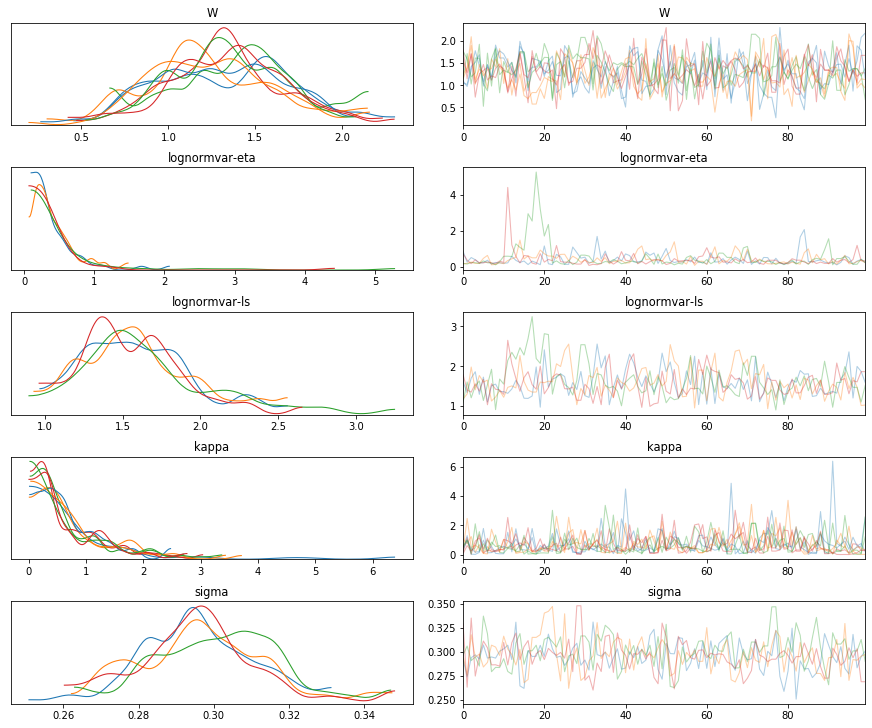

In [19]:
pm.traceplot(coregion_trace, combined=False, compact=True);

/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__

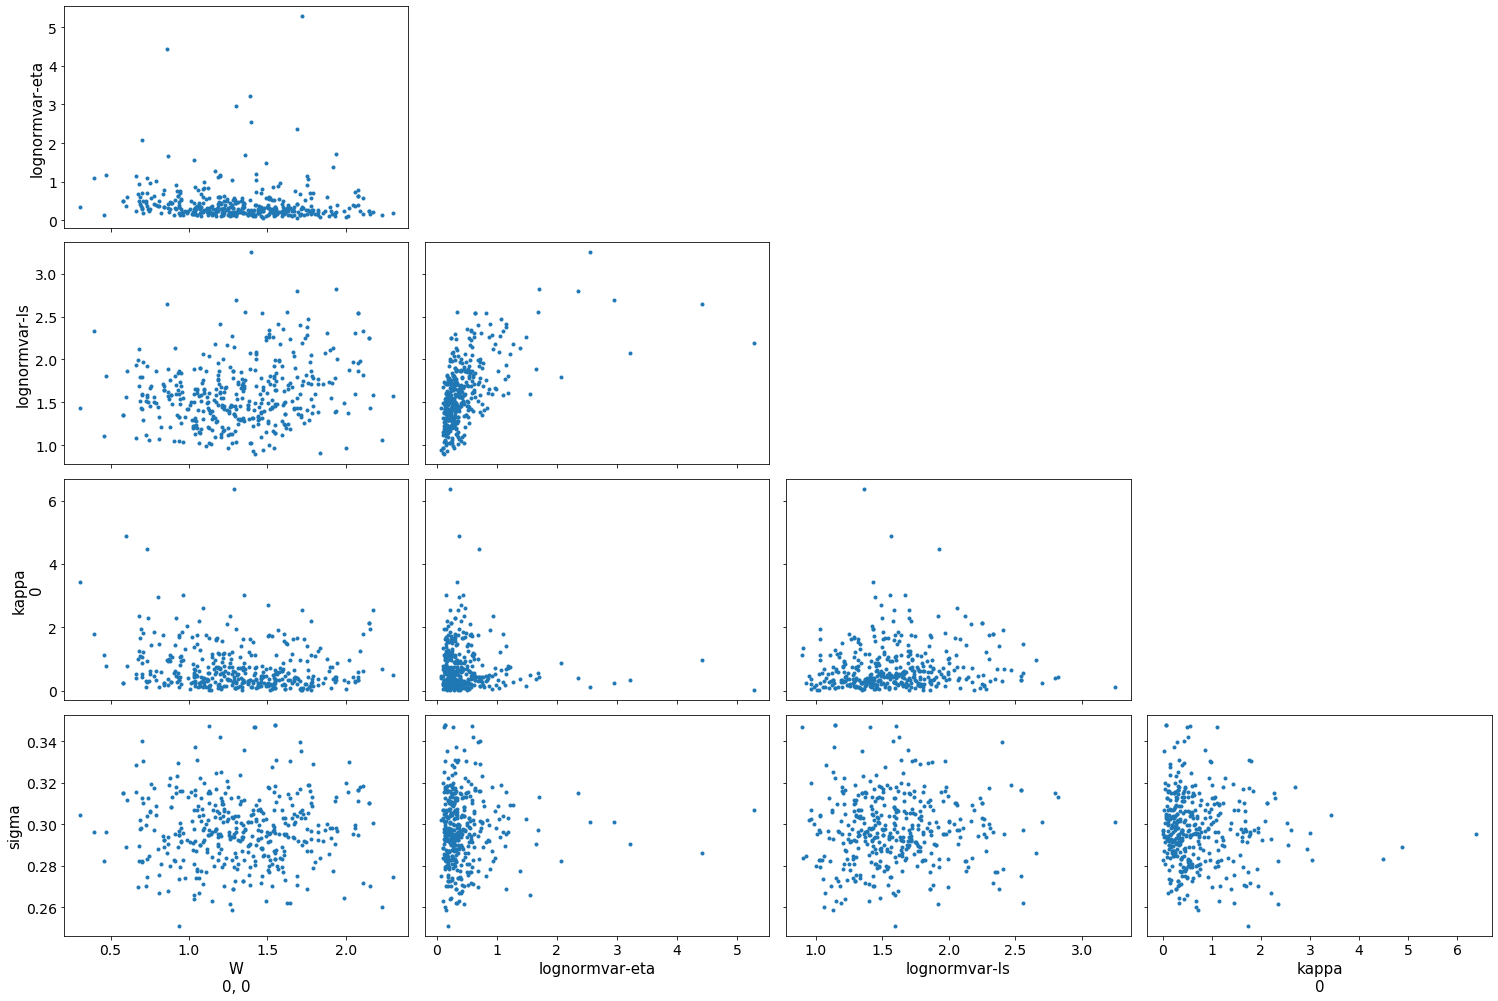

In [20]:
pm.pairplot(coregion_trace, divergences=True);

What do the two outputs look like?

In [21]:
nX_new = 600
XX_new = coregion_coords(np.linspace(0., 3. * np.pi, nX_new)[:, None], n_output=2)

with coregion_model:
    f_pred = gp.conditional("f_pred", XX_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with coregion_model:
    pred_samples = pm.sample_ppc(coregion_trace, vars=[f_pred], samples=100)

/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  if __na

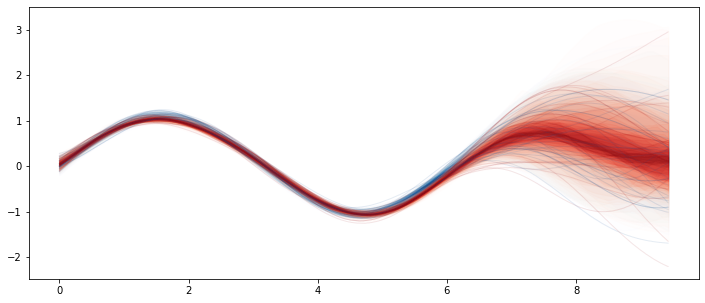

In [22]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
f_pred = pred_samples["f_pred"]
plot_gp_dist(ax, f_pred[:, :nX_new], XX_new[:nX_new,0], palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plot_gp_dist(ax, f_pred[:, nX_new:], XX_new[nX_new:,0], palette="Reds", fill_alpha=0.1, samples_alpha=0.1);

With this example out of the way, we can apply the same architecture to the spectroscopy

In [75]:
n_dspec_outputs = 4
dspec_use = dspec[:n_dspec_outputs]
dspec_use /= np.sqrt(np.median(dspec_use**2., axis=1, keepdims=True))

yy_full = coregion_outputs(list(dspec_use), n_output=n_dspec_outputs)
XX_full = coregion_coords(wave[:, None], n_dspec_outputs)

(-20.0, 20.0)

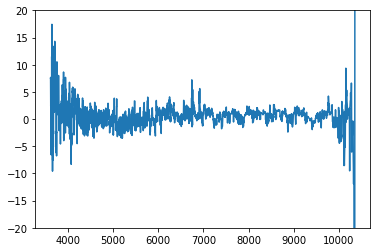

In [55]:
plt.plot(wave, dspec_use.T)
plt.ylim([-20., 20.])

In [12]:
n_use = 50
use = np.random.choice(np.linspace(0, XX_full.shape[0] - 1, XX_full.shape[0]).astype(int), n_use, replace=False)
XX_use, yy_use = XX_full[use, :], yy_full[use]

In [13]:
%%memit

W_shape = (n_dspec_outputs, 2)

with pm.Model() as dspec_coregion_model:
    # covariance scaling
    etasqr = pm.InverseGamma('etasqr', alpha=2., beta=20.)
    
    # first cov component: short ("ringing") scale
    ls_1000 = pm.Lognormal('ls1000', mu=0.5, sd=1.)
    ls = 1000. * ls_1000
    cov_short = etasqr * pm.gp.cov.ExpQuad(1, active_dims=[0], ls=ls)
    
    # coregion cov component
    coregion_W = pm.Normal('W', mu=1., sd=0.5, shape=W_shape, testval=1. + np.random.randn(*W_shape))
    coregion_kappa = pm.Gamma('kappa', alpha=1.5, beta=1., shape=n_dspec_outputs)
    coregion = pm.gp.cov.Coregion(1, active_dims=[1], W=coregion_W, kappa=coregion_kappa)
    
    # combine cov components
    cov = cov_short * coregion
    
    # mean
    mean_func = pm.gp.mean.Zero()
    
    # GP definition
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov)
    
    # observation noise
    sigma = pm.HalfNormal('sigma', sd=.25)
    
    y_ = gp.marginal_likelihood("y", X=XX_use, y=yy_use, noise=sigma)
    
    dspec_coregion_mp = pm.find_MAP()
    dspec_coregion_trace = pm.sample(100, init='advi+adapt_diag', start=dspec_coregion_mp)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '3244' (I am process '21514')
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic

NUTS: [sigma, kappa, W, ls1000, etasqr]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [02:09<00:00, 18.54draws/s]
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inter

peak memory: 510.13 MiB, increment: 222.01 MiB


In [28]:
dspec_coregion_model.profile(dspec_coregion_model.logpt).summary()

/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__

In [29]:
pm.summary(dspec_coregion_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"W[0,0]",0.298,0.274,-0.165,0.843,0.016,0.013,302.0,238.0,292.0,339.0,1.01
"W[0,1]",0.299,0.283,-0.201,0.807,0.016,0.016,300.0,162.0,305.0,227.0,1.03
"W[1,0]",0.916,0.413,0.190,1.711,0.026,0.019,250.0,239.0,250.0,242.0,1.01
"W[1,1]",0.929,0.426,0.119,1.648,0.027,0.019,252.0,252.0,253.0,261.0,1.02
"W[2,0]",1.320,0.521,0.440,2.375,0.043,0.030,146.0,146.0,162.0,301.0,1.03
"W[2,1]",1.238,0.573,0.143,2.300,0.035,0.027,267.0,226.0,257.0,180.0,1.01
etasqr,5.717,2.218,2.170,9.452,0.151,0.116,216.0,184.0,260.0,262.0,1.02
ls1000,0.044,0.008,0.027,0.059,0.000,0.000,289.0,265.0,310.0,151.0,1.02
kappa[0],0.263,0.257,0.002,0.649,0.014,0.010,318.0,313.0,281.0,129.0,1.01
kappa[1],1.081,0.906,0.066,2.825,0.045,0.034,399.0,350.0,371.0,244.0,1.00


/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98012f6390>,
      dtype=object)

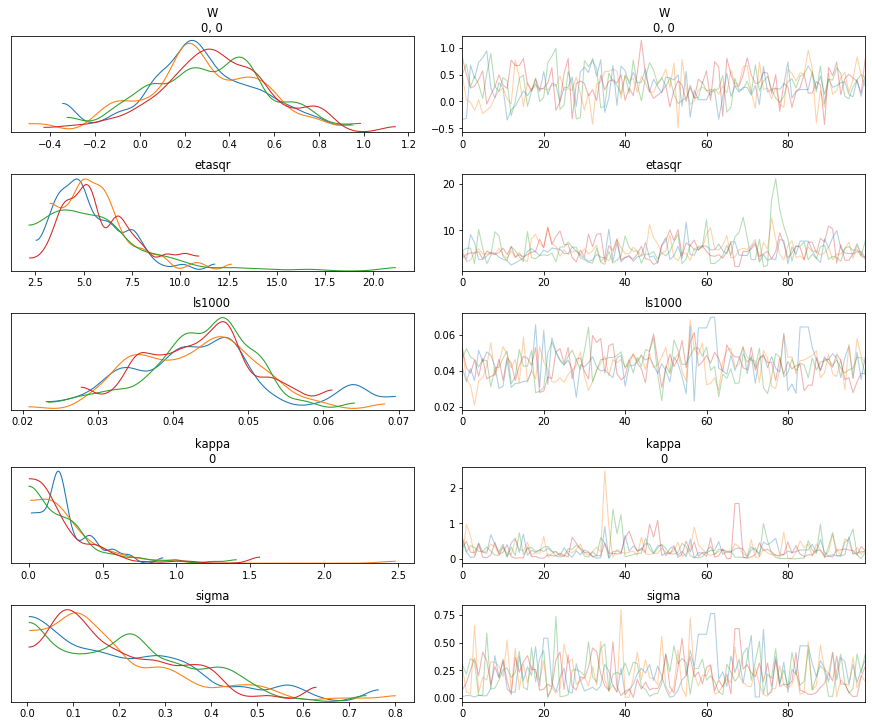

In [30]:
pm.traceplot(dspec_coregion_trace, compact=False)

/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98016ca150>,
      dtype=object)

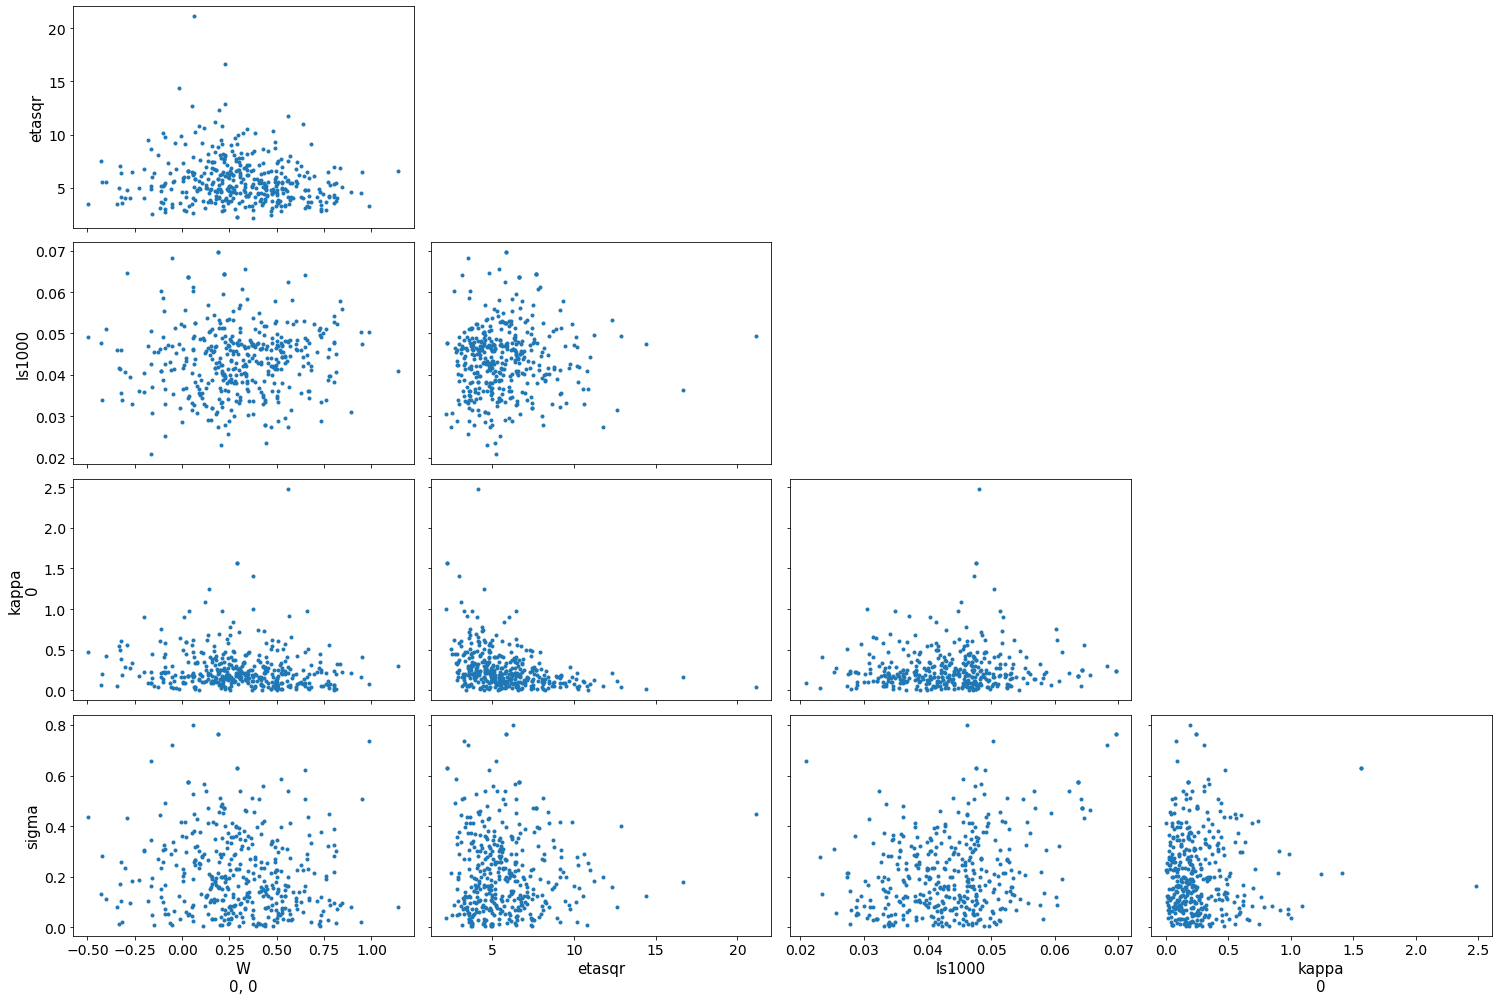

In [31]:
pm.pairplot(dspec_coregion_trace, divergences=True)

In [14]:
%%memit

pred_mean, pred_cov = gp.predict(np.column_stack([10**wave_log, np.full(wave_log.shape, 0.)]), point=dspec_coregion_mp)

/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  resul

peak memory: 3299.86 MiB, increment: 2789.73 MiB


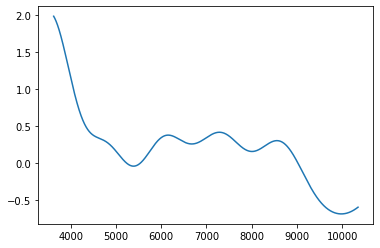

In [33]:
plt.plot(wave, pred_mean)

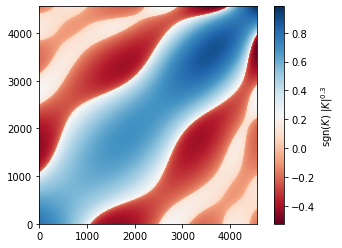

In [18]:
plt.imshow(np.sign(pred_cov) * np.abs(pred_cov)**.3, origin='lower', cmap='RdBu')
plt.colorbar(label=r'${\rm sgn}(K) ~ |K|^{0.3}$')

In [36]:
np.savetxt('manga_cov', pred_cov)
np.savetxt('manga_logl', wave_log)

Now try a transition to minibatch

In [76]:
minibatch_size = 512
XX_t = pm.Minibatch(XX_full, minibatch_size)
yy_t = pm.Minibatch(yy_full, minibatch_size)

/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/pymc3/data.py:246: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [80]:
W_rank = 2
W_shape = (n_dspec_outputs, W_rank)

with pm.Model() as dspec_coregion_mb_model:
    # covariance scaling
    etasqr = pm.InverseGamma('etasqr', alpha=2., beta=20.)
    
    # first cov component: short ("ringing") scale
    ls_1000 = pm.Lognormal('ls1000', mu=0.5, sd=1.)
    ls = 1000. * ls_1000
    cov_short = etasqr * pm.gp.cov.ExpQuad(1, active_dims=[0], ls=ls)
    
    # coregion cov component
    #coregion_W = pm.Normal('W', mu=0., sd=0.5, shape=W_shape, testval=np.full(W_shape, 0.1))
    coregion_kappa = pm.InverseGamma('kappa', alpha=1.5, beta=1.)
    coregion_WWt = pm.InverseGamma('WWt', alpha=1.5, beta=1.)
    coregion_B = coregion_WWt * tt.ones((n_dspec_outputs, n_dspec_outputs)) + \
                 coregion_kappa * tt.eye(n_dspec_outputs)
    coregion = pm.gp.cov.Coregion(1, active_dims=[1], B=coregion_B)
    
    # combine cov components
    cov = cov_short * coregion
    
    # mean
    mean_func = pm.gp.mean.Zero()
    
    # GP definition
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov)
    
    # observation noise
    sigma = pm.HalfNormal('sigma', sd=.25)
    
    y_ = gp.marginal_likelihood("y", X=XX_t, y=yy_t, noise=sigma, total_size=len(XX_full))
    
    #dspec_coregion_mb_trace = pm.sample(100, init='advi+adapt_diag', start=dspec_coregion_mp)
    dspec_coregion_mb_approx = pm.fit(10000)
    #step = pm.NUTS(scaling=dspec_coregion_mb_approx.cov.eval(), is_cov=True)
    #dspec_coregion_mb_trace = pm.sample(2000, step, start=dspec_coregion_mb_approx.sample()[0])

/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profi

ValueError: array must not contain infs or NaNs
Apply node that caused the error: Cholesky{lower=True, destructive=False, on_error='nan'}(Elemwise{Composite{((i0 * i1) + i2)}}[(0, 2)].0)
Toposort index: 134
Inputs types: [TensorType(float32, matrix)]
Inputs shapes: [(512, 512)]
Inputs strides: [(2048, 4)]
Inputs values: ['not shown']
Outputs clients: [[ExtractDiag{offset=0, axis1=0, axis2=1, view=False}(Cholesky{lower=True, destructive=False, on_error='nan'}.0), Elemwise{isnan,no_inplace}(Cholesky{lower=True, destructive=False, on_error='nan'}.0), Elemwise{switch,no_inplace}(Elemwise{Invert}[(0, 0)].0, Cholesky{lower=True, destructive=False, on_error='nan'}.0, TensorConstant{(1, 1) of 1}), Elemwise{Switch}[(0, 1)](InplaceDimShuffle{x,x}.0, Cholesky{lower=True, destructive=False, on_error='nan'}.0, TensorConstant{(1, 1) of 1})]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-80-f334233bb92d>", line 33, in <module>
    y_ = gp.marginal_likelihood("y", X=XX_t, y=yy_t, noise=sigma, total_size=len(XX_full))
  File "/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/pymc3/gp/gp.py", line 424, in marginal_likelihood
    return pm.MvNormal(name, mu=mu, cov=cov, observed=y, **kwargs)
  File "/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/pymc3/distributions/distribution.py", line 46, in __new__
    dist = cls.dist(*args, **kwargs)
  File "/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/pymc3/distributions/distribution.py", line 57, in dist
    dist.__init__(*args, **kwargs)
  File "/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/pymc3/distributions/multivariate.py", line 222, in __init__
    super().__init__(mu=mu, cov=cov, tau=tau, chol=chol, lower=lower, *args, **kwargs)
  File "/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/pymc3/distributions/multivariate.py", line 62, in __init__
    self.chol_cov = cholesky(cov)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [29]:
dspec_coregion_model.profile(dspec_coregion_model.logpt).summary()

/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__

In [71]:
%%memit
minibatch_pred, minibatch_cov = gp.predict(np.column_stack([10.**wave_log, np.full(wave_log.shape, 0.)]), point=dspec_coregion_mb_approx.sample(1)[0])

/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__

peak memory: 4887.21 MiB, increment: 108.25 MiB


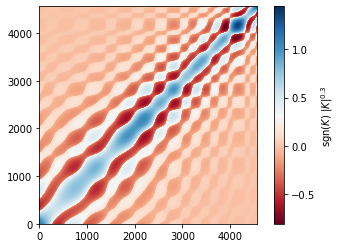

In [72]:
plt.imshow(np.sign(minibatch_cov) * np.abs(minibatch_cov)**.3, origin='lower', cmap='RdBu')
plt.colorbar(label=r'${\rm sgn}(K) ~ |K|^{0.3}$')

In [74]:
dspec_coregion_mb_approx.sample(1)['WWt']

array([0.90518755], dtype=float32)

In [ ]:
%%memit

pred_mean, pred_cov = gp.predict(np.column_stack([10**wave_log, np.full(wave_log.shape, 0.)]), point=dspec_coregion_mp)

In [29]:
pm.summary(dspec_coregion_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"W[0,0]",0.298,0.274,-0.165,0.843,0.016,0.013,302.0,238.0,292.0,339.0,1.01
"W[0,1]",0.299,0.283,-0.201,0.807,0.016,0.016,300.0,162.0,305.0,227.0,1.03
"W[1,0]",0.916,0.413,0.190,1.711,0.026,0.019,250.0,239.0,250.0,242.0,1.01
"W[1,1]",0.929,0.426,0.119,1.648,0.027,0.019,252.0,252.0,253.0,261.0,1.02
"W[2,0]",1.320,0.521,0.440,2.375,0.043,0.030,146.0,146.0,162.0,301.0,1.03
"W[2,1]",1.238,0.573,0.143,2.300,0.035,0.027,267.0,226.0,257.0,180.0,1.01
etasqr,5.717,2.218,2.170,9.452,0.151,0.116,216.0,184.0,260.0,262.0,1.02
ls1000,0.044,0.008,0.027,0.059,0.000,0.000,289.0,265.0,310.0,151.0,1.02
kappa[0],0.263,0.257,0.002,0.649,0.014,0.010,318.0,313.0,281.0,129.0,1.01
kappa[1],1.081,0.906,0.066,2.825,0.045,0.034,399.0,350.0,371.0,244.0,1.00


/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98012f6390>,
      dtype=object)

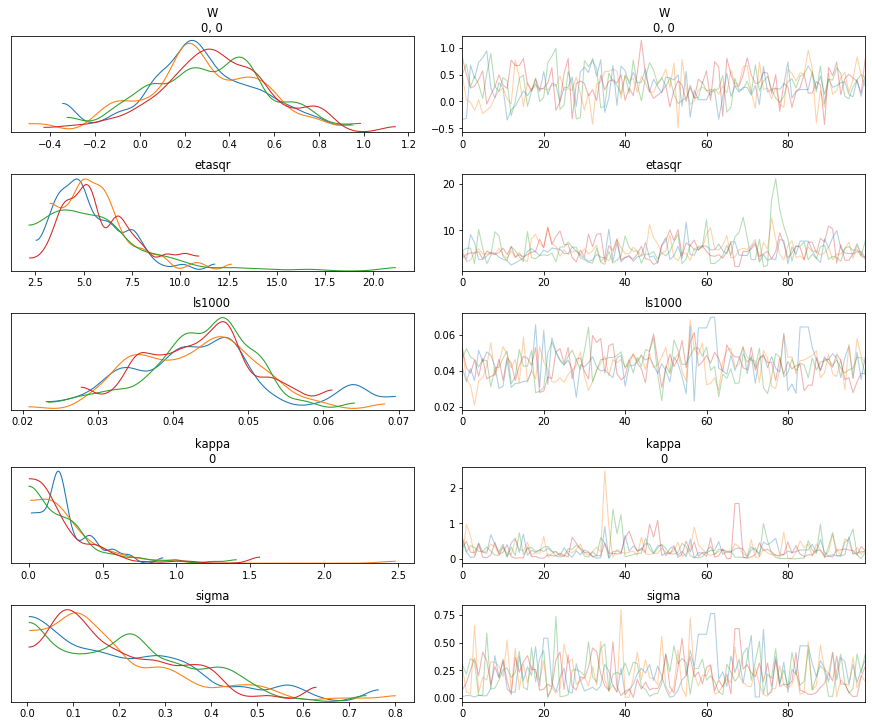

In [30]:
pm.traceplot(dspec_coregion_trace, compact=False)

/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/zpace/miniconda3/envs/manga-cov/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98016ca150>,
      dtype=object)

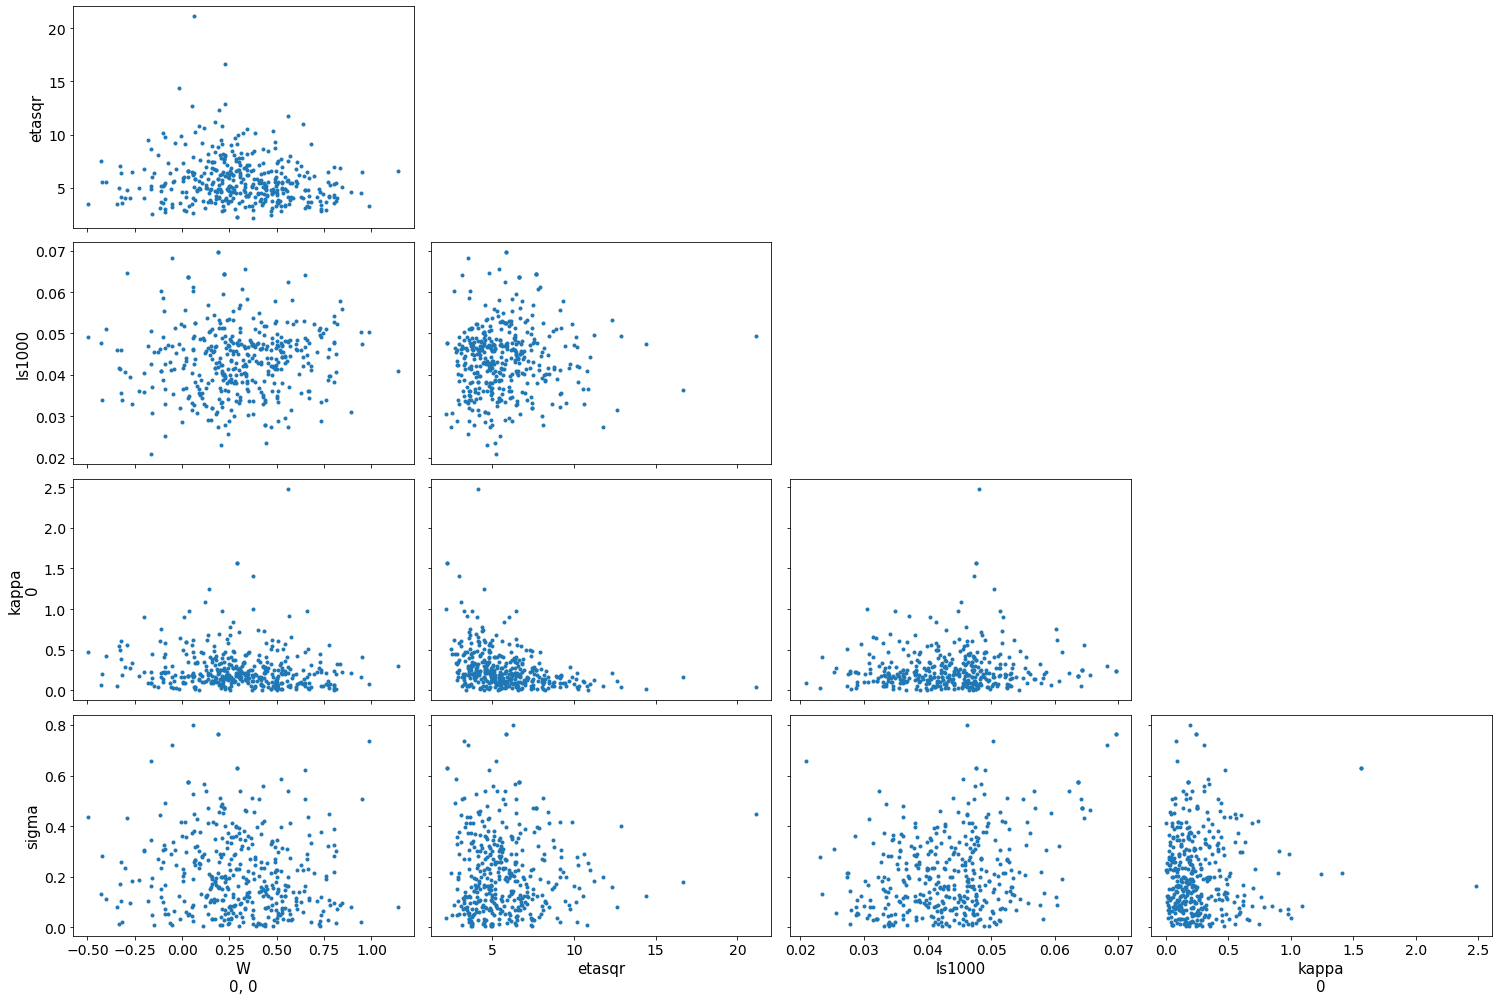

In [31]:
pm.pairplot(dspec_coregion_trace, divergences=True)